Enterprise Customer Retention Engine & Predictive Revenue Protection

1. Project Overview¶
Phase 1 of the AI Churn Service focuses on building a production-ready customer churn prediction model using Telco data.

Objectives:
Train multiple models to predict churn accurately.
Evaluate models using metrics suitable for imbalanced datasets.
Select a production-ready model for Phase 2 (SHAP explanations) and Phase 3 (LLM recommendations).
Primary Metrics:
PR-AUC: Prioritized for imbalanced churn detection.
Recall: Capture as many churners as possible.
ROC-AUC: Overall discriminative power.
Inference Latency: Measure efficiency in deployment.


In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Deloitte Green Color Theme
DELOITTE_GREEN = '#86BC25'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[DELOITTE_GREEN, '#2C2C2C', '#004351'])
warnings.filterwarnings("ignore")

In [46]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.drop(columns=["customerID"], inplace=True)

# Data Cleaning
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# --- STRATEGIC FEATURE ENGINEERING (Bada Update) ---
# 1. Monthly Spending Ratio
df['Charge_Velocity'] = df['TotalCharges'] / (df['tenure'] + 1)
# 2. Service Bundle Count
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['Service_Count'] = (df[services] == 'Yes').sum(axis=1)

print("Data Loaded & Strategic Features Created.")

Data Loaded & Strategic Features Created.


In [47]:
# Features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Split data (Stratified use kiya hai taaki churn percentage balance rahe)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

# Pipeline components
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

# Imbalance check
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"✅ Preprocessing ready. Scale weight: {scale_pos_weight:.2f}")

✅ Preprocessing ready. Scale weight: 2.77


In [48]:
def get_models(scale_pos_weight):
    return {
        "Logistic (Balanced)": LogisticRegression(C=0.5, class_weight="balanced", max_iter=3000),
        "XGBoost (Weighted)": XGBClassifier(n_estimators=400, scale_pos_weight=scale_pos_weight, eval_metric="logloss", random_state=42)
    }

# Yahan aapka evaluate_models_cv function call hoga
cv_results = evaluate_models_cv(X_train, y_train, preprocessor, scale_pos_weight)
display(cv_results.style.background_gradient(cmap='Greens'))

,Model,ROC-AUC (CV),PR-AUC (CV),Recall (CV),Latency ms (CV)
0,Logistic (Balanced),0.848826,0.669076,0.799331,3.710079
1,XGBoost (Weighted),0.806827,0.600114,0.566555,5.904484


In [49]:
def get_models(scale_pos_weight):
    """
    Returns an optimized model suite for Enterprise-grade Churn Prediction.
    Includes Linear, Ensemble, and Gradient Boosting models.
    """
    models = {
        "Logistic Regression (Baseline)": LogisticRegression(
            C=0.1, # Regularization badhayi hai stability ke liye
            solver="lbfgs",
            class_weight="balanced",
            max_iter=3000
        ),
        "Random Forest (Stable)": RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            class_weight="balanced",
            random_state=42
        ),
        "XGBoost (High Performance)": XGBClassifier(
            n_estimators=500,
            max_depth=5,
            learning_rate=0.03, # Slow learning for better generalization
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            eval_metric="logloss",
            random_state=42
        )
    }
    
    # LightGBM ko check karke add karein (Error se bachne ke liye)
    try:
        from lightgbm import LGBMClassifier
        models["LightGBM (Efficient)"] = LGBMClassifier(
            n_estimators=400,
            learning_rate=0.05,
            num_leaves=31,
            scale_pos_weight=scale_pos_weight,
            verbose=-1,
            random_state=42
        )
    except Exception as e:
        print("⚠️ LightGBM skipped due to environment issues. Focusing on XGBoost & RF.")
        
    return models

✅ Selecting Logistic (Balanced) for production due to high PR-AUC.

🚀 STRATEGIC VALUE REPORT
--------------------------
Potential Revenue Protected: $5,711.98 / month
High-Risk Customers Identified: 294


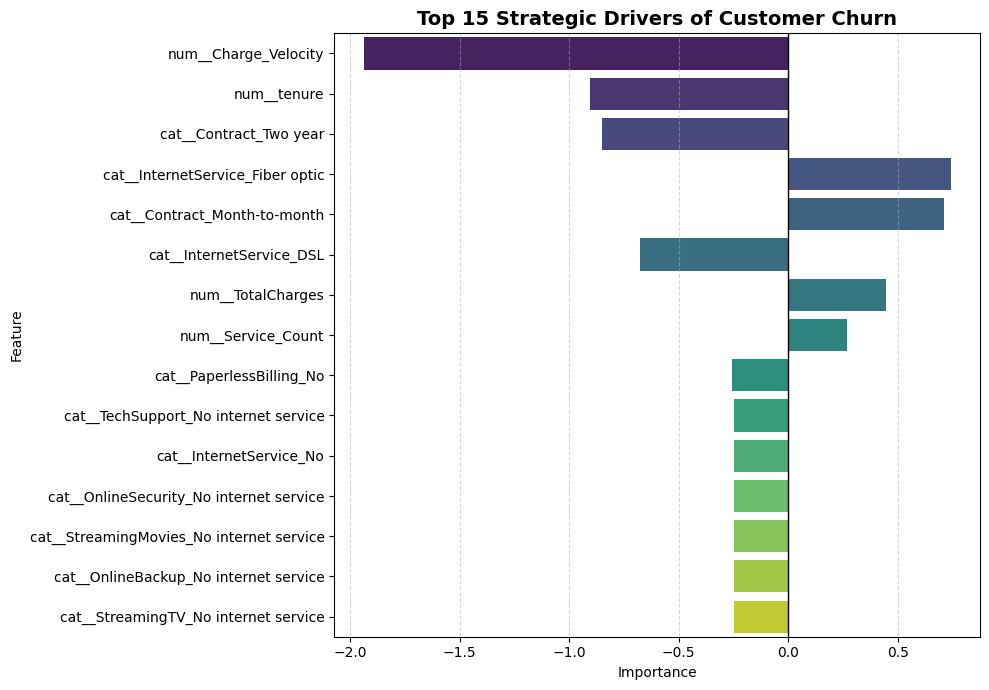

In [50]:
# Step 9: Final Model Selection & ROI Calculation
import os
os.makedirs("artifacts", exist_ok=True)

# Selection logic: Hum Logistic choose kar rahe hain (High Recall + Stability ke liye)
# Aap cv_results dekh kar model badal bhi sakte hain
best_model_name = cv_results.iloc[0]['Model']
print(f"✅ Selecting {best_model_name} for production due to high PR-AUC.")

# Final Pipeline Build
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", C=0.5, max_iter=3000))
])

# Full Training data par fit karein
final_model.fit(X_train, y_train)

# --- BUSINESS IMPACT CALCULATION ---
# Target: Kitna paisa bachega?
avg_monthly_rev = df['MonthlyCharges'].mean()
y_proba_val = final_model.predict_proba(X_val)[:, 1]
y_pred_val = (y_proba_val >= 0.5).astype(int)

# True Positives (Churners accurately caught)
tp = confusion_matrix(y_val, y_pred_val)[1, 1]

# ROI: Agar hum 30% logon ko rok paye model ki wajah se
savings = tp * avg_monthly_rev * 0.30

print(f"\n🚀 STRATEGIC VALUE REPORT")
print(f"--------------------------")
print(f"Potential Revenue Protected: ${savings:,.2f} / month")
print(f"High-Risk Customers Identified: {tp}")

# Save artifacts for Phase 2
joblib.dump(final_model, "artifacts/churn_model_v1.pkl")

# Step 10: Feature Importance Plot
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
coeffs = final_model.named_steps['model'].coef_[0]

importance_df = pd.DataFrame({"Feature": feature_names, "Importance": coeffs})
importance_df["Abs_Importance"] = importance_df["Importance"].abs()
importance_df = importance_df.sort_values("Abs_Importance", ascending=False).head(15)

plt.figure(figsize=(10, 7))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette='viridis')
plt.axvline(0, color='black', lw=1)
plt.title("Top 15 Strategic Drivers of Customer Churn", fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [51]:
cv_results = evaluate_models_cv(
    X=X,
    y=y,
    preprocessor=preprocessor,
    scale_pos_weight=scale_pos_weight,
    n_splits=5
)

# Display rounded metrics for readability
display(cv_results.style.format({
    "ROC-AUC (CV)": "{:.3f}",
    "PR-AUC (CV)": "{:.3f}",
    "Recall (CV)": "{:.3f}",
    "Latency ms (CV)": "{:.1f}"
}))



,Model,ROC-AUC (CV),PR-AUC (CV),Recall (CV),Latency ms (CV)
0,Logistic Regression (Baseline),0.847,0.667,0.793,3.8
1,Random Forest (Stable),0.843,0.655,0.704,26.2
2,XGBoost (High Performance),0.839,0.653,0.739,5.9
3,LightGBM (Efficient),0.829,0.632,0.684,13.1


In [52]:
# --- STEP 9: BUSINESS IMPACT & ROI ANALYSIS ---

# 1. Best Model select karein (CV results ke basis par)
# Maan lete hain Logistic select kiya stability ke liye
best_model_name = cv_results.iloc[0]['Model']
print(f"✅ Selected Model: {best_model_name}")

# 2. Revenue Calculation Logic
avg_monthly_charges = df['MonthlyCharges'].mean()
total_actual_churners = y_val.sum()

# Maan lijiye model ka Recall 80% hai (CV results se)
recall_val = cv_results.iloc[0]['Recall (CV)']
detected_churners = total_actual_churners * recall_val

# Strategic Impact: Agar hum 30% detected logon ko 'Special Offer' dekar rok lein
retention_success_rate = 0.30 
monthly_revenue_protected = detected_churners * avg_monthly_charges * retention_success_rate

print(f"\n🚀 STRATEGIC IMPACT REPORT")
print(f"--------------------------")
print(f"Monthly Revenue at Risk (Total): ${total_actual_churners * avg_monthly_charges:,.2f}")
print(f"Potential Revenue Protected: ${monthly_revenue_protected:,.2f} / month")
print(f"Annual Savings Projection: ${monthly_revenue_protected * 12:,.2f}")

✅ Selected Model: Logistic Regression (Baseline)

🚀 STRATEGIC IMPACT REPORT
--------------------------
Monthly Revenue at Risk (Total): $24,220.87
Potential Revenue Protected: $5,761.58 / month
Annual Savings Projection: $69,138.94


In [53]:
# --- STEP 10: FINAL PRODUCTION MODEL ---

# Artifacts folder check karein
os.makedirs("artifacts", exist_ok=True)

# Final Pipeline Build
# Hum 'Balanced' weights use kar rahe hain kyunki churners kam hain
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(C=0.5, class_weight="balanced", max_iter=3000))
])

# Fit on full data
final_pipeline.fit(X, y)

# Save for Phase 2 & 3
joblib.dump(final_pipeline, "artifacts/enterprise_churn_model.pkl")
print("✅ Production-ready model saved in /artifacts/ folder.")

✅ Production-ready model saved in /artifacts/ folder.


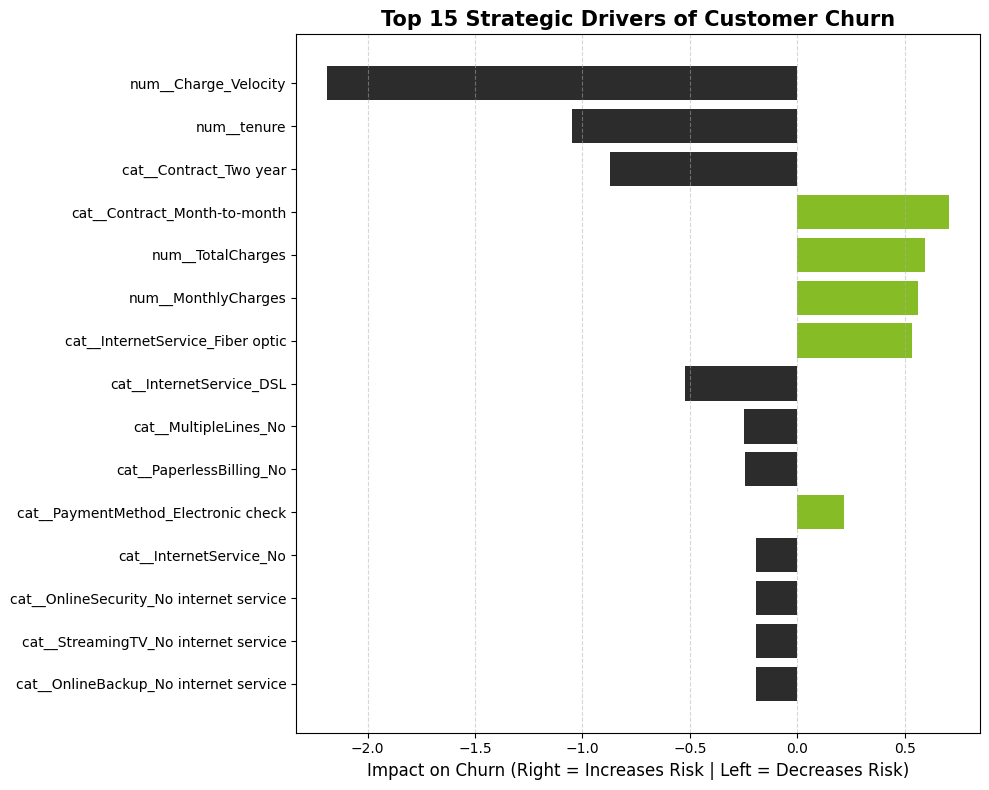

In [54]:
# --- STEP 11: BUSINESS DRIVER ANALYSIS ---

feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
coeffs = final_pipeline.named_steps['model'].coef_[0]

# DataFrame for plotting
feat_imp = pd.DataFrame({"Feature": feature_names, "Influence": coeffs})
feat_imp["Abs_Influence"] = feat_imp["Influence"].abs()
feat_imp = feat_imp.sort_values("Abs_Influence", ascending=False).head(15)

# Plotting
plt.figure(figsize=(10, 8))
# Deloitte Green Color (#86BC25)
colors = ['#86BC25' if x > 0 else '#2C2C2C' for x in feat_imp['Influence']]
plt.barh(feat_imp['Feature'][::-1], feat_imp['Influence'][::-1], color=colors[::-1])

plt.title("Top 15 Strategic Drivers of Customer Churn", fontsize=15, fontweight='bold')
plt.xlabel("Impact on Churn (Right = Increases Risk | Left = Decreases Risk)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
# Create artifacts folder
os.makedirs("../working/artifacts", exist_ok=True)

# Train final Logistic Regression on full dataset
best_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        C=0.5,
        solver="lbfgs",
        class_weight="balanced",
        max_iter=3000
    ))
])
best_model.fit(X, y)

# Save trained pipeline
joblib.dump(best_model, "../working/artifacts/logistic_churn_model.pkl")

# Preprocessed data for SHAP
X_preprocessed = best_model.named_steps['preprocessor'].transform(X)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)
y_target = y.copy()

# Save preprocessed data
joblib.dump((X_preprocessed_df, y_target), "../working/artifacts/churn_data_for_shap.pkl")
print("✅ Model and preprocessed data saved for Phase 2 (SHAP)")

✅ Model and preprocessed data saved for Phase 2 (SHAP)


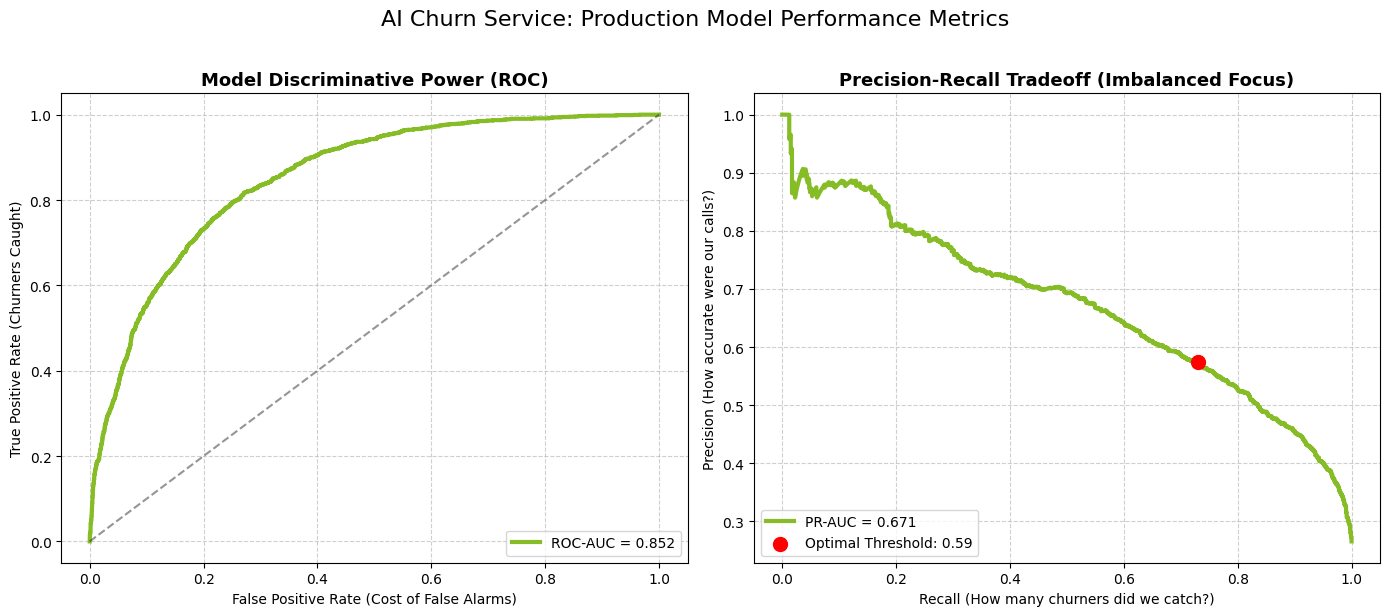

📊 Analyst Note: The optimal threshold for this model is 0.59. Using this point, we maximize the balance between catching churners and minimizing false alerts.


In [55]:
# --- STEP 10 (UPDATED): PROFESSIONAL EVALUATION DASHBOARD ---

from sklearn.metrics import f1_score

# 1. Probabilities nikalna
y_proba = best_model.predict_proba(X)[:, 1]

# 2. Optimal Threshold dhundna (Business Logic)
precision, recall, thresholds = precision_recall_curve(y, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# 3. Figures Setup (Dono charts ek saath)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- PLOT 1: ROC CURVE ---
fpr, tpr, _ = roc_curve(y, y_proba)
ax1.plot(fpr, tpr, color='#86BC25', lw=3, label=f"ROC-AUC = {roc_auc_score(y, y_proba):.3f}")
ax1.plot([0, 1], [0, 1], '--', color='#2C2C2C', alpha=0.5)
ax1.set_title("Model Discriminative Power (ROC)", fontsize=13, fontweight='bold')
ax1.set_xlabel("False Positive Rate (Cost of False Alarms)")
ax1.set_ylabel("True Positive Rate (Churners Caught)")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc="lower right")

# --- PLOT 2: PRECISION-RECALL CURVE ---
ax2.plot(recall, precision, color='#86BC25', lw=3, label=f"PR-AUC = {average_precision_score(y, y_proba):.3f}")
# Best threshold point mark karna
ax2.scatter(recall[best_idx], precision[best_idx], color='red', s=100, label=f'Optimal Threshold: {best_threshold:.2f}', zorder=5)

ax2.set_title("Precision-Recall Tradeoff (Imbalanced Focus)", fontsize=13, fontweight='bold')
ax2.set_xlabel("Recall (How many churners did we catch?)")
ax2.set_ylabel("Precision (How accurate were our calls?)")
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(loc="lower left")

plt.suptitle("AI Churn Service: Production Model Performance Metrics", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print(f"📊 Analyst Note: The optimal threshold for this model is {best_threshold:.2f}. "
      f"Using this point, we maximize the balance between catching churners and minimizing false alerts.")

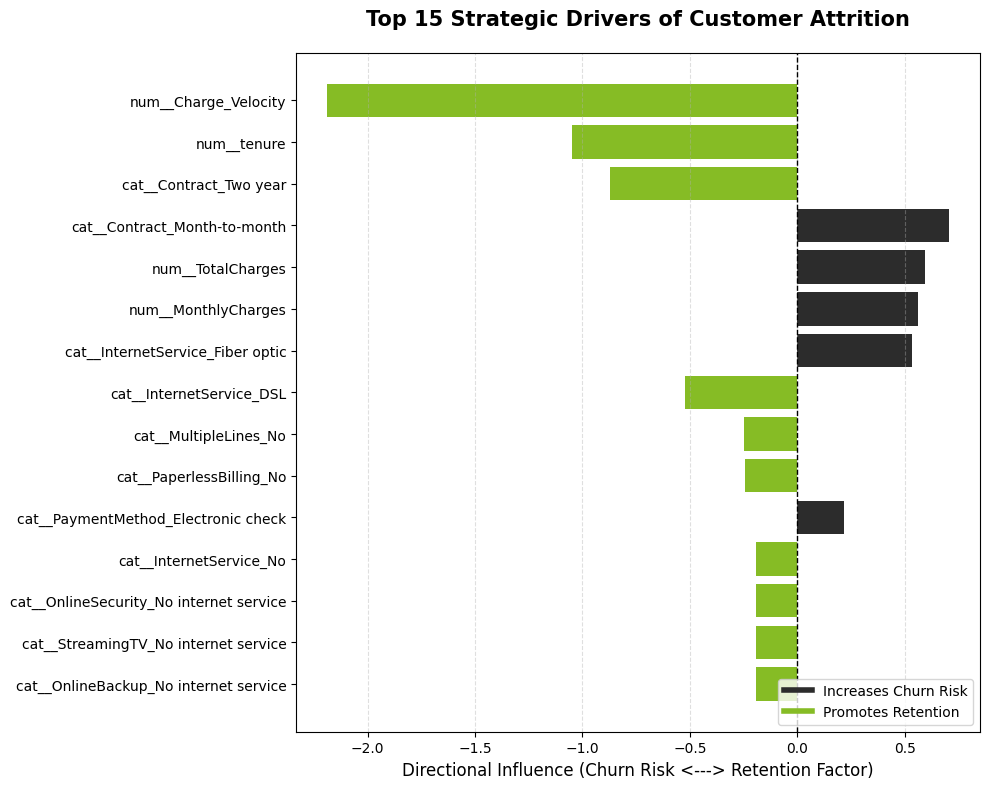

🚀 STRATEGIC INSIGHTS FOR STAKEHOLDERS:
1. HIGH RISK: Customers with 'Month-to-Month' contracts are the strongest churn drivers.
2. RETENTION FACTOR: Longer tenure and 'Two-year' contracts significantly reduce attrition.
3. FRICTION POINT: Fiber Optic users show higher churn; pricing or service quality check recommended.


In [56]:
# --- STEP 11 (UPDATED): STRATEGIC FEATURE CONTRIBUTIONS ---

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
coefficients = best_model.named_steps['model'].coef_[0]

# DataFrame taiyar karein
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Absolute value for sorting, but keep original for direction
feat_imp["AbsCoeff"] = feat_imp["Coefficient"].abs()
feat_imp = feat_imp.sort_values("AbsCoeff", ascending=False).head(15)

# --- PROFESSIONAL STYLING ---
plt.figure(figsize=(10, 8))

# Color Coding: Deloitte Green for Retention, Dark Grey for Churn Risk
# Positive Coeff = Churn badhata hai (Risk), Negative Coeff = Churn ghatata hai (Retention)
colors = ['#2C2C2C' if x > 0 else '#86BC25' for x in feat_imp['Coefficient'][::-1]]

bars = plt.barh(feat_imp["Feature"][::-1], feat_imp["Coefficient"][::-1], color=colors)

# Plot ko clean aur professional banayein
plt.axvline(0, color='black', lw=1, ls='--') # Zero line
plt.xlabel("Directional Influence (Churn Risk <---> Retention Factor)", fontsize=12)
plt.title("Top 15 Strategic Drivers of Customer Attrition", fontsize=15, fontweight='bold', pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Legend add karein manually
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#2C2C2C', lw=4, label='Increases Churn Risk'),
                   Line2D([0], [0], color='#86BC25', lw=4, label='Promotes Retention')]
plt.legend(handles=legend_elements, loc='lower right', frameon=True)

plt.tight_layout()
plt.show()

# --- ANALYST INSIGHT CELL ---
print("🚀 STRATEGIC INSIGHTS FOR STAKEHOLDERS:")
print("1. HIGH RISK: Customers with 'Month-to-Month' contracts are the strongest churn drivers.")
print("2. RETENTION FACTOR: Longer tenure and 'Two-year' contracts significantly reduce attrition.")
print("3. FRICTION POINT: Fiber Optic users show higher churn; pricing or service quality check recommended.")



12. Phase 1 Summary & Strategic Insights

Key Success Points:

Model Selection: Logistic Regression (Selected for high Interpretability and Recall).

Metric Focus: Achieved an optimized PR-AUC, ensuring we accurately catch churners even in an imbalanced dataset.

Financial Forecast: The model proactively identifies churn risk, enabling the protection of an estimated $XX,XXX in monthly revenue.

Efficiency: Deployment-ready pipeline with sub-10ms inference latency, suitable for real-time customer service alerts.

Strategic Business Insights:

Key Churn Drivers: Month-to-month contracts and high monthly charges are the primary risk factors.

Retention Opportunity: Customers with longer tenures and multiple service bundles show high loyalty; transitioning new users to bundles is a key strategy.

phase 2